## Exercise to detect Algorithmically Generated Domain Names.
In this notebook we're going to use some great python modules to explore, understand and classify domains as being 'legit' or having a high probability of being generated by a DGA (Dynamic Generation Algorithm). We have 'legit' in quotes as we're using the domains in Alexa as the 'legit' set. The primary motivation is to explore the nexus of IPython, Pandas and scikit-learn with DGA classification as a vehicle for that exploration. The exercise intentionally shows common missteps, warts in the data, paths that didn't work out that well and results that could definitely be improved upon. In general capturing what worked and what didn't is not only more realistic but often much more informative. :)

### Python Modules Used:
- Pandas: Python Data Analysis Library (http://pandas.pydata.org)
- Scikit Learn (http://scikit-learn.org) Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
- Matplotlib:  Python 2D plotting library (http://matplotlib.org)

**Suggestions/Comments:**
Please send suggestions or bugs (I'm sure) to *clicklabs at clicksecurity.com*. Also if you have some datasets or would like to explore alternative approaches please touch base.



In [1]:
import sklearn.feature_extraction
sklearn.__version__

'0.19.0'

In [231]:
import sys
sys.version

'3.6.2 (default, Aug 25 2017, 16:07:15) \n[GCC 4.2.1 Compatible Apple LLVM 8.1.0 (clang-802.0.42)]'

In [2]:
import pandas as pd
pd.__version__

'0.20.3'

In [4]:
import pylab
# Set default pylab stuff
pylab.rcParams['figure.figsize'] = (14.0, 5.0)
pylab.rcParams['axes.grid'] = True

In [15]:
# Version 0.12.0 of Pandas has a DeprecationWarning about Height blah that I'm ignoring
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [16]:
# This is the Alexa 100k domain list, we're not using the 1 Million just for speed reasons. Results
# for the Alexa 1M are given at the bottom of the notebook.
alexa_dataframe = pd.read_csv('data/alexa_100k.csv', names=['rank','uri'], header=None, encoding='utf-8')
alexa_dataframe.head()

,rank,uri
0,1,facebook.com
1,2,google.com
2,3,youtube.com
3,4,yahoo.com
4,5,baidu.com


In [17]:
import numpy as np
# Okay for this exercise we need the 2LD and nothing else
import tldextract

def domain_extract(uri):
    ext = tldextract.extract(uri)
    if (not ext.suffix):
        return np.nan
    else:
        return ext.domain

alexa_dataframe['domain'] = [ domain_extract(uri) for uri in alexa_dataframe['uri']]
del alexa_dataframe['rank']
del alexa_dataframe['uri']
alexa_dataframe.head()

,domain
0,facebook
1,google
2,youtube
3,yahoo
4,baidu


In [18]:
alexa_dataframe.tail()

,domain
99995,rhbabyandchild
99996,rm
99997,sat1
99998,nahimunkar
99999,musi


In [25]:
# It's possible we have NaNs from blanklines or whatever
alexa_dataframe = alexa_dataframe.dropna()
alexa_dataframe = alexa_dataframe.drop_duplicates()

# Set the class
alexa_dataframe['class'] = 'legit'

# Shuffle the data (important for training/testing)
alexa_dataframe = alexa_dataframe.reindex(np.random.permutation(alexa_dataframe.index))
alexa_total = alexa_dataframe.shape[0]
print('Total Alexa domains {:d}'.format(alexa_total))

# Hold out 10%
hold_out_alexa = alexa_dataframe[int(alexa_total*.9):]
alexa_dataframe = alexa_dataframe[:int(alexa_total*.9)]

print('Number of Alexa domains: {:d}'.format(alexa_dataframe.shape[0]))

Total Alexa domains 82239
Number of Alexa domains: 74015


In [26]:
alexa_dataframe.head()

,domain,class
71140,oooxm,legit
86410,timlo,legit
10903,penthouse,legit
90133,elitebank,legit
17107,vbseo,legit


In [31]:
# Read in the DGA domains
dga_dataframe = pd.read_csv('data/dga_domains.txt', names=['raw_domain'], header=None, encoding='utf-8')

# We noticed that the blacklist values just differ by captilization or .com/.org/.info
dga_dataframe['domain'] = dga_dataframe.applymap(lambda x: x.split('.')[0].strip().lower())
del dga_dataframe['raw_domain']

# It's possible we have NaNs from blanklines or whatever
dga_dataframe = dga_dataframe.dropna()
dga_dataframe = dga_dataframe.drop_duplicates()
dga_total = dga_dataframe.shape[0]
print('Total DGA domains {:d}'.format(dga_total))

# Set the class
dga_dataframe['class'] = 'dga'

# Hold out 10%
hold_out_dga = dga_dataframe[int(dga_total*.9):]
dga_dataframe = dga_dataframe[:int(dga_total*.9)]

print('Number of DGA domains: {:d}'.format(dga_dataframe.shape[0]))

Total DGA domains 2664
Number of DGA domains: 2397


In [32]:
dga_dataframe.head()

,domain,class
0,04055051be412eea5a61b7da8438be3d,dga
1,1cb8a5f36f,dga
2,30acd347397c34fc273e996b22951002,dga
3,336c986a284e2b3bc0f69f949cb437cb,dga
5,40a43e61e56a5c218cf6c22aca27f7ee,dga


In [33]:
# Concatenate the domains in a big pile!
all_domains = pd.concat([alexa_dataframe, dga_dataframe], ignore_index=True)

In [35]:
# Add a length field for the domain
all_domains['length'] = [len(x) for x in all_domains['domain']]

# Okay since we're trying to detect dynamically generated domains and short
# domains (length <=6) are crazy random even for 'legit' domains we're going
# to punt on short domains (perhaps just white/black list for short domains?)
all_domains = all_domains[all_domains['length'] > 6]

In [36]:
# Grabbed this from Rosetta Code (rosettacode.org)
import math
from collections import Counter
 
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

In [37]:
# Add a entropy field for the domain
all_domains['entropy'] = [entropy(x) for x in all_domains['domain']]

In [38]:
all_domains.head()

,domain,class,length,entropy
2,penthouse,legit,9,2.947703
3,elitebank,legit,9,2.947703
6,theeroticreview,legit,15,2.973557
7,bookmarkinglambda,legit,17,3.337175
8,submitsitetodirectories,legit,23,3.240528


In [39]:
all_domains.tail()

,domain,class,length,entropy
76407,ulxxqduryvv,dga,11,2.913977
76408,ummvzhin,dga,8,2.750000
76409,umsgnwgc,dga,8,2.750000
76410,umzsbhpkrgo,dga,11,3.459432
76411,umzuyjrfwyf,dga,11,2.913977


## Lets plot some stuff!

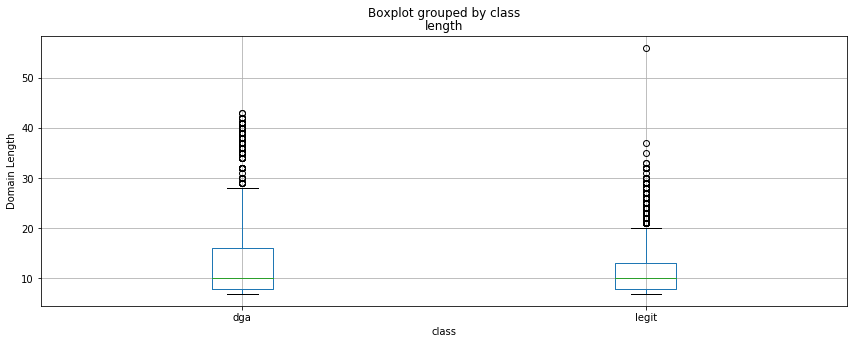

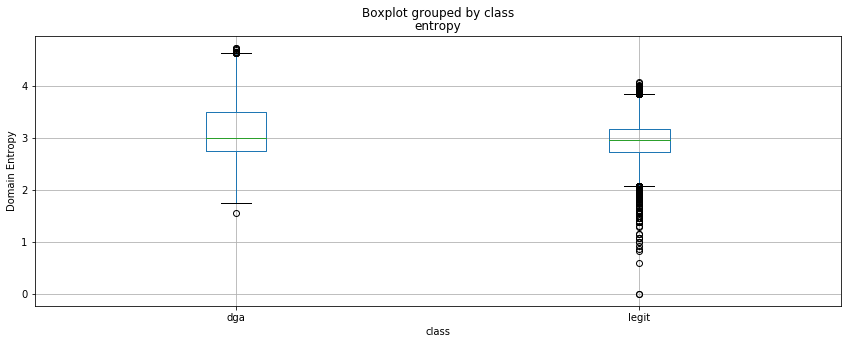

In [42]:
# Boxplots show you the distribution of the data (spread).
# http://en.wikipedia.org/wiki/Box_plot

# Plot the length and entropy of domains
all_domains.boxplot('length','class')
pylab.ylabel('Domain Length')
all_domains.boxplot('entropy','class')
pylab.ylabel('Domain Entropy')
pylab.show()

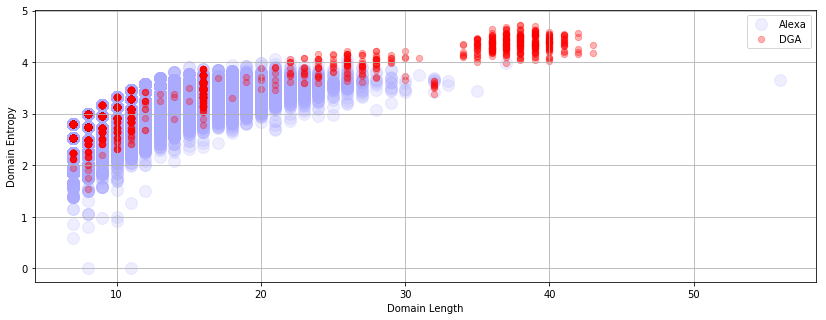

In [46]:
from matplotlib import pyplot as plt
# Split the classes up so we can set colors, size, labels
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
alexa = all_domains[~cond]
plt.scatter(alexa['length'], alexa['entropy'], s=140, c='#aaaaff', label='Alexa', alpha=.2)
plt.scatter(dga['length'], dga['entropy'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
pylab.xlabel('Domain Length')
pylab.ylabel('Domain Entropy')
pylab.show()

# Below you can see that our DGA domains do tend to have higher entropy than Alexa on average.

In [78]:
# Lets look at the types of domains that have entropy higher than 4
high_entropy_domains = all_domains[all_domains['entropy'] > 4]
print('Num Domains above 4 entropy: {:.2f}% {:d} (out of {:d})'.format(100.0*high_entropy_domains.shape[0]/all_domains.shape[0], high_entropy_domains.shape[0], all_domains.shape[0]))      
print("Num high entropy legit: {:d}".format(high_entropy_domains[high_entropy_domains['class']=='legit'].shape[0]))
print("Num high entropy DGA: {:d}".format(high_entropy_domains[high_entropy_domains['class']=='dga'].shape[0]))
high_entropy_domains[high_entropy_domains['class']=='legit'].head()

# Looking at the results below, we do see that there are more domains
# in the DGA group that are high entropy but only a small percentage
# of the domains are in that high entropy range...

Num Domains above 4 entropy: 0.63% 361 (out of 56911)
Num high entropy legit: 3
Num high entropy DGA: 358


,domain,class,length,entropy
8504,burzhunetdlyachaynikov,legit,22,4.004886
11905,theukwebdesigncompany,legit,21,4.070656
46325,congresomundialjjrperu2009,legit,26,4.056021


In [79]:
high_entropy_domains[high_entropy_domains['class']=='dga'].head()

,domain,class,length,entropy
74033,a17btkyb38gxe41pwd50nxmzjxiwjwdwfrp52,dga,37,4.540402
74034,a17c49l68ntkqnuhvkrmyb28fubvn30e31g43dq,dga,39,4.631305
74035,a17d60gtnxk47gskti15izhvlviyksh64nqkz,dga,37,4.270132
74036,a17erpzfzh64c69csi35bqgvp52drita67jzmy,dga,38,4.629249
74037,a17fro51oyk67b18ksfzoti55j36p32o11fvc29cr,dga,41,4.305859


In [80]:
# In preparation for using scikit learn we're just going to use
# some handles that help take us from pandas land to scikit land

# List of feature vectors (scikit learn uses 'X' for the matrix of feature vectors)
X = all_domains.as_matrix(['length', 'entropy'])

# Labels (scikit learn uses 'y' for classification labels)
y = np.array(all_domains['class'].tolist()) # Yes, this is weird but it needs 
                                            # to be an np.array of strings

In [81]:
# Random Forest is a popular ensemble machine learning classifier.
# http://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#
import sklearn.ensemble
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20) # Trees in the forest

In [82]:
from sklearn.model_selection import cross_val_score
# Now we can use scikit learn's cross validation to assess predictive performance.
# http://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics
scores = cross_val_score(clf, X, y, cv=5, n_jobs=4)
print(scores)

[ 0.96494773  0.96538698  0.96678967  0.96512037  0.96046042]


In [83]:
# Wow 96% accurate! At this point we could claim success and we'd be gigantic morons...
# Recall that we have ~100k 'legit' domains and only 3.5k DGA domains
# So a classifier that marked everything as legit would be about
# 96% accurate....

# So we dive in a bit and look at the predictive performance more deeply.

# Train on a 80/20 split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Confusion Matrix Stats
legit/legit 99.93% (10899/10907)
legit/dga 0.07% (8/10907)
dga/legit 81.93% (390/476)
dga/dga 18.07% (86/476)


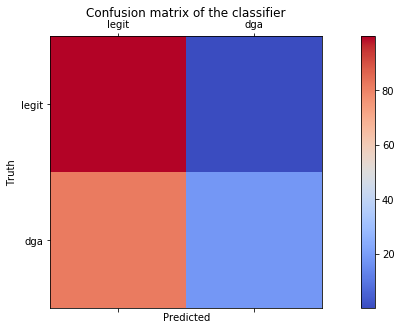

In [85]:
# Now plot the results of the 80/20 split in a confusion matrix
from sklearn.metrics import confusion_matrix
labels = ['legit', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)

def plot_cm(cm, labels):
    
    # Compute percentanges
    percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T)  # Derp, I'm sure there's a better way
    
    print('Confusion Matrix Stats')
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print("{:s}/{:s} {:.2f}% ({:d}/{:d})".format(label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum()))

    # Show confusion matrix
    # Thanks kermit666 from stackoverflow :)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='coolwarm')
    pylab.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    pylab.xlabel('Predicted')
    pylab.ylabel('Truth')
    pylab.show()

plot_cm(cm, labels)

# We can see below that our suspicions were correct and the classifier is
# marking almost everything as Alexa. We FAIL.. science is hard... lets go drinking....

In [86]:
# Well our Mom told us we were still cool.. so with that encouragement we're
# going to compute NGrams for every Alexa domain and see if we can use the
# NGrams to help us better differentiate and mark DGA domains...

# Scikit learn has a nice NGram generator that can generate either char NGrams or word NGrams (we're using char).
# Parameters: 
#       - ngram_range=(3,5)  # Give me all ngrams of length 3, 4, and 5
#       - min_df=1e-4        # Minimumum document frequency. At 1e-4 we're saying give us NGrams that 
#                            # happen in at least .1% of the domains (so for 100k... at least 100 domains)
alexa_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-4, max_df=1.0)

In [87]:
# I'm SURE there's a better way to store all the counts but not sure...
# At least the min_df parameters has already done some thresholding
counts_matrix = alexa_vc.fit_transform(alexa_dataframe['domain'])
alexa_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = alexa_vc.get_feature_names()

In [97]:
# For fun sort it and show it
import operator
_sorted_ngrams = sorted(zip(ngrams_list, alexa_counts), key=operator.itemgetter(1), reverse=True)
print('Alexa NGrams: {:d}'.format(len(_sorted_ngrams)))
for ngram, count in _sorted_ngrams[:10]:
    print(ngram, count)

Alexa NGrams: 24408
ing 3.35410843915
lin 3.33905373571
ine 3.30963016743
tor 3.17522180034
ter 3.17493159353
ion 3.15381486434
ent 3.13576851457
the 3.11159852488
por 3.10448711131
ree 3.0715138051


In [99]:
# We're also going to throw in a bunch of dictionary words
word_dataframe = pd.read_csv('data/words.txt', names=['word'], header=None, dtype={'word': np.str}, encoding='utf-8')

# Cleanup words from dictionary
word_dataframe = word_dataframe[word_dataframe['word'].map(lambda x: str(x).isalpha())]
word_dataframe = word_dataframe.applymap(lambda x: str(x).strip().lower())
word_dataframe = word_dataframe.dropna()
word_dataframe = word_dataframe.drop_duplicates()
word_dataframe.head(10)

,word
37,a
48,aa
51,aaa
53,aaaa
54,aaaaaa
55,aaal
56,aaas
57,aaberg
58,aachen
59,aae


In [100]:
# Now compute NGrams on the dictionary words
# Same logic as above...
dict_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-5, max_df=1.0)
counts_matrix = dict_vc.fit_transform(word_dataframe['word'])
dict_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = dict_vc.get_feature_names()

In [103]:
# For fun sort it and show it
import operator
_sorted_ngrams = sorted(zip(ngrams_list, dict_counts), key=operator.itemgetter(1), reverse=True)
print('Word NGrams: {:d}'.format(len(_sorted_ngrams)))
for ngram, count in _sorted_ngrams[:10]:
    print(ngram, count)

Word NGrams: 123061
ing 4.38730082245
ess 4.20487933376
ati 4.19334725639
ion 4.16503647999
ter 4.16241503611
nes 4.11250445877
tio 4.07682242334
ate 4.07236020396
ent 4.06963110262
tion 4.04960561259


In [114]:
# We use the transform method of the CountVectorizer to form a vector
# of ngrams contained in the domain, that vector is than multiplied
# by the counts vector (which is a column sum of the count matrix).
def ngram_count(domain):
    alexa_match = alexa_counts * alexa_vc.transform([domain]).T  # Woot vector multiply and transpose Woo Hoo!
    dict_match = dict_counts * dict_vc.transform([domain]).T
    print('{:s} Alexa match:{:.2f} Dict match: {:.2f}'.format(domain, alexa_match[0], dict_match[0]))

# Examples:
ngram_count('google')
ngram_count('facebook')
ngram_count('1cb8a5f36f')
ngram_count('pterodactylfarts')
ngram_count('ptes9dro-dwacty2lfa5rrts')
ngram_count('beyonce')
ngram_count('bey666on4ce')

google Alexa match:16.61 Dict match: 14.87
facebook Alexa match:29.84 Dict match: 27.87
1cb8a5f36f Alexa match:0.00 Dict match: 0.00
pterodactylfarts Alexa match:33.75 Dict match: 76.42
ptes9dro-dwacty2lfa5rrts Alexa match:18.60 Dict match: 28.10
beyonce Alexa match:14.93 Dict match: 16.16
bey666on4ce Alexa match:2.74 Dict match: 1.85


In [115]:
# Compute NGram matches for all the domains and add to our dataframe
all_domains['alexa_grams']= alexa_counts * alexa_vc.transform(all_domains['domain']).T 
all_domains['word_grams']= dict_counts * dict_vc.transform(all_domains['domain']).T 
all_domains.head()

,domain,class,length,entropy,alexa_grams,word_grams
2,penthouse,legit,9,2.947703,29.435071,49.712190
3,elitebank,legit,9,2.947703,31.196702,37.623715
6,theeroticreview,legit,15,2.973557,53.945802,72.704067
7,bookmarkinglambda,legit,17,3.337175,76.518779,80.169119
8,submitsitetodirectories,legit,23,3.240528,119.025189,122.816012


In [116]:
all_domains.tail()

,domain,class,length,entropy,alexa_grams,word_grams
76407,ulxxqduryvv,dga,11,2.913977,3.706547,6.464859
76408,ummvzhin,dga,8,2.750000,6.011414,7.180022
76409,umsgnwgc,dga,8,2.750000,3.096910,3.847079
76410,umzsbhpkrgo,dga,11,3.459432,1.623249,2.546543
76411,umzuyjrfwyf,dga,11,2.913977,0.000000,0.000000


In [119]:
# Use the vectorized operations of the dataframe to investigate differences
# between the alexa and word grams
all_domains['diff'] = all_domains['alexa_grams'] - all_domains['word_grams']
all_domains.sort_values(['diff'], ascending=True).head(10)

# The table below shows those domain names that are more 'dictionary' and less 'web'

,domain,class,length,entropy,alexa_grams,word_grams,diff
728,bipolardisorderdepressionanxiety,legit,32,3.616729,110.210774,190.833856,-80.623082
34901,stirringtroubleinternationally,legit,30,3.481728,128.794355,207.204729,-78.410374
17959,americansforresponsiblesolutions,legit,32,3.667838,141.412041,218.363956,-76.951915
35452,channel4embarrassingillnesses,legit,29,3.440070,92.265408,169.119440,-76.854032
41158,mythoughtsideasandramblings,legit,27,3.884155,93.078030,156.295588,-63.217558
33465,nationalcherryblossomfestival,legit,29,3.857307,103.129383,166.143920,-63.014537
56486,pragmatismopolitico,legit,19,3.326360,58.689547,121.536223,-62.846676
59425,interoperabilitybridges,legit,23,3.588354,91.245231,153.626312,-62.381081
74270,canadianpharmaceuticalsorg,dga,26,3.690260,81.528714,143.316082,-61.787368
38886,carbohydratecolumns,legit,19,3.826875,39.844490,100.669951,-60.825461


In [120]:
all_domains.sort_values(['diff'], ascending=False).head(50)

# The table below shows those domain names that are more 'web' and less 'dictionary'
# Good O' web....

,domain,class,length,entropy,alexa_grams,word_grams,diff
34557,gay-sex-pics-porn-pictures-gay-sex-porn-gay-se...,legit,56,3.661056,154.932019,85.124184,69.807835
21419,social-bookmarking-sites-list,legit,29,3.702472,140.783043,102.261826,38.521218
47480,online-web-directory,legit,20,3.584184,112.360126,74.082948,38.277178
819,best-online-shopping-site,legit,25,3.452879,117.761757,79.596640,38.165117
43731,xxx-porno-sexvideos,legit,19,3.260828,72.271225,34.574489,37.696737
47071,free-online-directory,legit,21,3.403989,117.542609,80.735030,36.807578
4771,free-links-articles-directory,legit,29,3.702472,147.374860,110.955361,36.419499
19863,free-tv-video-online,legit,20,3.284184,81.417846,45.662984,35.754862
14345,web-directory-online,legit,20,3.584184,109.722409,74.082948,35.639461
68137,freegamesforyourwebsite,legit,23,3.551191,111.985822,77.311761,34.674062


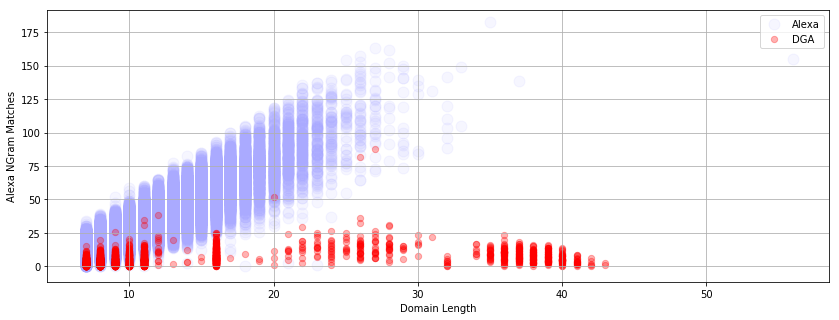

In [122]:
# Lets plot some stuff!
# Here we want to see whether our new 'alexa_grams' feature can help us differentiate between Legit/DGA
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]
plt.scatter(legit['length'], legit['alexa_grams'], s=120, c='#aaaaff', label='Alexa', alpha=.1)
plt.scatter(dga['length'], dga['alexa_grams'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
pylab.xlabel('Domain Length')
pylab.ylabel('Alexa NGram Matches')
pylab.show()

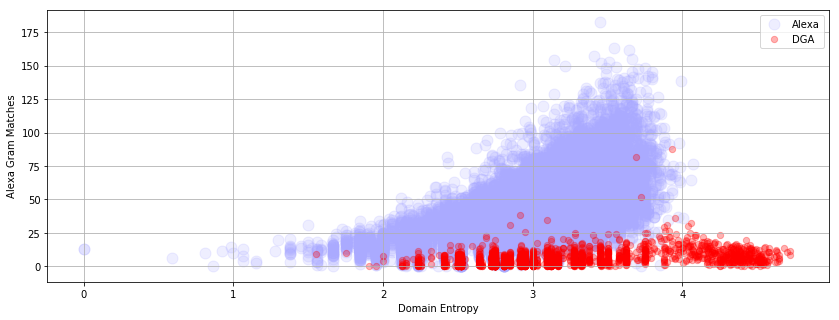

In [125]:
# Lets plot some stuff!
# Here we want to see whether our new 'alexa_grams' feature can help us differentiate between Legit/DGA
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]
plt.scatter(legit['entropy'], legit['alexa_grams'],  s=120, c='#aaaaff', label='Alexa', alpha=.2)
plt.scatter(dga['entropy'], dga['alexa_grams'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
pylab.xlabel('Domain Entropy')
pylab.ylabel('Alexa Gram Matches')
pylab.show()

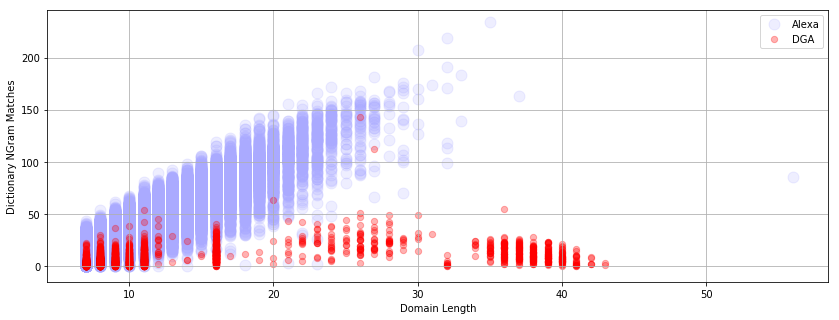

In [126]:
# Lets plot some stuff!
# Here we want to see whether our new 'word_grams' feature can help us differentiate between Legit/DGA
# Note: It doesn't look quite as good as the Alexa_grams but it might generalize better (less overfit).
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]
plt.scatter(legit['length'], legit['word_grams'],  s=120, c='#aaaaff', label='Alexa', alpha=.2)
plt.scatter(dga['length'], dga['word_grams'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
pylab.xlabel('Domain Length')
pylab.ylabel('Dictionary NGram Matches')
pylab.show()

In [127]:
# Lets look at which Legit domains are scoring low on the word gram count
all_domains[(all_domains['word_grams']==0)].head()

,domain,class,length,entropy,alexa_grams,word_grams,diff
74,vi-vi-vi,legit,8,1.561278,3.266937,0.0,3.266937
2299,1532888,legit,7,2.128085,1.643453,0.0,1.643453
2730,ih8sn0w,legit,7,2.807355,0.000000,0.0,0.000000
4121,dns-dns,legit,7,1.950212,6.480282,0.0,6.480282
4232,blt17688,legit,8,2.750000,1.079181,0.0,1.079181


In [128]:
# Okay these look kinda weird, lets use some nice Pandas functionality
# to look at some statistics around our new features.
all_domains[all_domains['class']=='legit'].describe()

,length,entropy,alexa_grams,word_grams,diff
count,54514.000000,54514.000000,54514.000000,54514.000000,54514.000000
mean,10.865392,2.929987,32.082579,40.733239,-8.650660
std,3.392043,0.347078,18.803119,23.306066,9.546680
min,7.000000,-0.000000,0.000000,0.000000,-80.623082
25%,8.000000,2.725481,18.446359,23.901477,-13.815758
50%,10.000000,2.947703,27.820966,36.134041,-7.801745
75%,13.000000,3.169925,41.085726,52.912042,-2.584382
max,56.000000,4.070656,182.466920,233.648571,69.807835


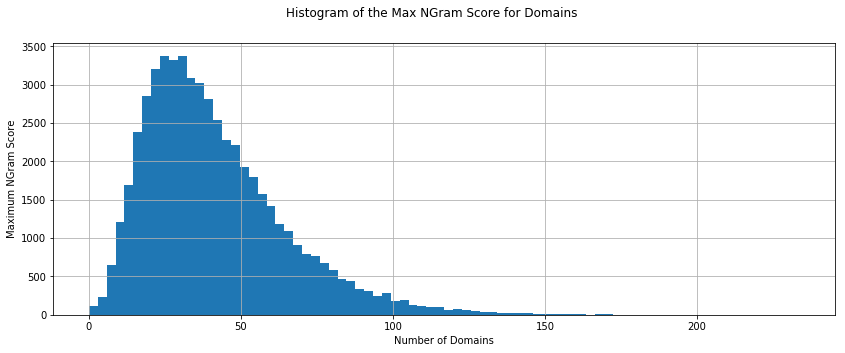

In [129]:
# Lets look at how many domains that are both low in word_grams and alexa_grams (just plotting the max of either)
legit = all_domains[(all_domains['class']=='legit')]
max_grams = np.maximum(legit['alexa_grams'],legit['word_grams'])
ax = max_grams.hist(bins=80)
ax.figure.suptitle('Histogram of the Max NGram Score for Domains')
pylab.xlabel('Number of Domains')
pylab.ylabel('Maximum NGram Score')
pylab.show()

In [131]:
# Lets look at which Legit domains are scoring low on both alexa and word gram count
weird_cond = (all_domains['class']=='legit') & (all_domains['word_grams']<3) & (all_domains['alexa_grams']<2)
weird = all_domains[weird_cond]
print(weird.shape[0])
weird.head(30)

74


,domain,class,length,entropy,alexa_grams,word_grams,diff
1280,zgqmbbs,legit,7,2.521641,1.740363,1.322219,0.418143
2299,1532888,legit,7,2.128085,1.643453,0.000000,1.643453
2730,ih8sn0w,legit,7,2.807355,0.000000,0.000000,0.000000
3269,jzbybyw,legit,7,2.235926,1.954243,1.924279,0.029963
3823,xn--42cgk1gc8crdb1htg3d,legit,23,3.849224,1.278754,2.411620,-1.132866
4232,blt17688,legit,8,2.750000,1.079181,0.000000,1.079181
5869,ptnrlnk,legit,7,2.521641,0.000000,1.447158,-1.447158
6024,9to5lol,legit,7,2.235926,1.919078,2.359835,-0.440757
6040,1325827506,legit,10,2.921928,0.903090,0.000000,0.903090
6458,fzysqmy,legit,7,2.521641,1.079181,0.000000,1.079181


In [132]:
# Epiphany... Alexa really may not be the best 'exemplar' set...  
#             (probably a no-shit moment for everyone else :)
#
# Discussion: If you're using these as exemplars of NOT DGA, then your probably
#             making things very hard on your machine learning algorithm.
#             Perhaps we should have two categories of Alexa domains, 'legit'
#             and a 'weird'. based on some definition of weird.
#             Looking at the entries above... we have approx 80 domains
#             that we're going to mark as 'weird'.
#
all_domains.loc[weird_cond, 'class'] = 'weird'
print(all_domains['class'].value_counts())
all_domains[all_domains['class'] == 'weird'].head()

legit    54440
dga       2397
weird       74
Name: class, dtype: int64


,domain,class,length,entropy,alexa_grams,word_grams,diff
1280,zgqmbbs,weird,7,2.521641,1.740363,1.322219,0.418143
2299,1532888,weird,7,2.128085,1.643453,0.000000,1.643453
2730,ih8sn0w,weird,7,2.807355,0.000000,0.000000,0.000000
3269,jzbybyw,weird,7,2.235926,1.954243,1.924279,0.029963
3823,xn--42cgk1gc8crdb1htg3d,weird,23,3.849224,1.278754,2.411620,-1.132866


In [133]:
# Now we try our machine learning algorithm again with the new features
# Alexa and Dictionary NGrams and the exclusion of the bad exemplars.
X = all_domains.as_matrix(['length', 'entropy', 'alexa_grams', 'word_grams'])

# Labels (scikit learn uses 'y' for classification labels)
y = np.array(all_domains['class'].tolist())

# Train on a 80/20 split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Confusion Matrix Stats
legit/legit 99.52% (10863/10915)
legit/weird 0.00% (0/10915)
legit/dga 0.48% (52/10915)
weird/legit 0.00% (0/14)
weird/weird 28.57% (4/14)
weird/dga 71.43% (10/14)
dga/legit 14.76% (67/454)
dga/weird 1.32% (6/454)
dga/dga 83.92% (381/454)


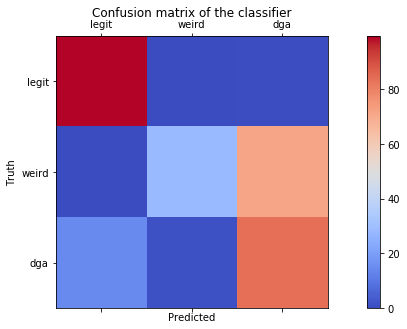

In [134]:
# Now plot the results of the 80/20 split in a confusion matrix
labels = ['legit', 'weird', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm, labels)

In [135]:
# Hun, well that seem to work 'ok', but you don't really want a classifier
# that outputs 3 classes, you'd like a classifier that flags domains as DGA or not.
# This was a path that seemed like a good idea until it wasn't....

In [136]:
# Perhaps we will just exclude the weird class from our ML training
not_weird = all_domains[all_domains['class'] != 'weird']
X = not_weird.as_matrix(['length', 'entropy', 'alexa_grams', 'word_grams'])

# Labels (scikit learn uses 'y' for classification labels)
y = np.array(not_weird['class'].tolist())

# Train on a 80/20 split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Confusion Matrix Stats
legit/legit 99.54% (10843/10893)
legit/dga 0.46% (50/10893)
dga/legit 14.32% (68/475)
dga/dga 85.68% (407/475)


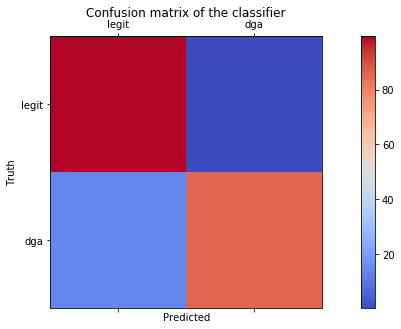

In [137]:
# Now plot the results of the 80/20 split in a confusion matrix
labels = ['legit', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm, labels) 

In [138]:
# Well it's definitely better.. but haven't we just cheated by removing
# the weird domains?  Well perhaps, but on some level we're removing
# outliers that are bad exemplars. So to validate that the model is still
# doing the right thing lets try our new model prediction on our hold out sets.

# First train on the whole thing before looking at prediction performance
clf.fit(X, y)

# Pull together our hold out set
hold_out_domains = pd.concat([hold_out_alexa, hold_out_dga], ignore_index=True)

# Add a length field for the domain
hold_out_domains['length'] = [len(x) for x in hold_out_domains['domain']]
hold_out_domains = hold_out_domains[hold_out_domains['length'] > 6]

# Add a entropy field for the domain
hold_out_domains['entropy'] = [entropy(x) for x in hold_out_domains['domain']]

# Compute NGram matches for all the domains and add to our dataframe
hold_out_domains['alexa_grams']= alexa_counts * alexa_vc.transform(hold_out_domains['domain']).T
hold_out_domains['word_grams']= dict_counts * dict_vc.transform(hold_out_domains['domain']).T

hold_out_domains.head()

,domain,class,length,entropy,alexa_grams,word_grams
0,cleoporn,legit,8,2.750000,22.258371,30.768040
1,bollysnap,legit,9,2.947703,19.879030,25.662767
2,baranpatogh,legit,11,3.027169,30.224555,38.784451
3,forex-masr,legit,10,3.121928,24.681876,17.876159
4,cinemageddon,legit,12,3.084963,37.534155,51.171431


Confusion Matrix Stats
legit/legit 99.20% (5965/6013)
legit/dga 0.80% (48/6013)
dga/legit 13.86% (37/267)
dga/dga 86.14% (230/267)


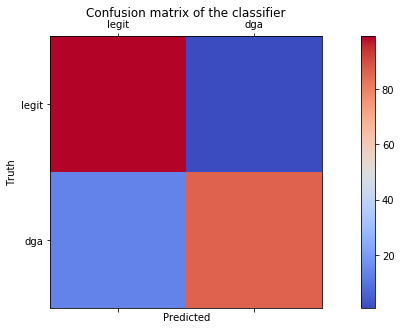

In [139]:
# List of feature vectors (scikit learn uses 'X' for the matrix of feature vectors)
hold_X = hold_out_domains.as_matrix(['length', 'entropy', 'alexa_grams', 'word_grams'])

# Labels (scikit learn uses 'y' for classification labels)
hold_y = np.array(hold_out_domains['class'].tolist())

# Now run through the predictive model
hold_y_pred = clf.predict(hold_X)

# Add the prediction array to the dataframe
hold_out_domains['pred'] = hold_y_pred

# Now plot the results
labels = ['legit', 'dga']
cm = confusion_matrix(hold_y, hold_y_pred, labels)
plot_cm(cm, labels) 

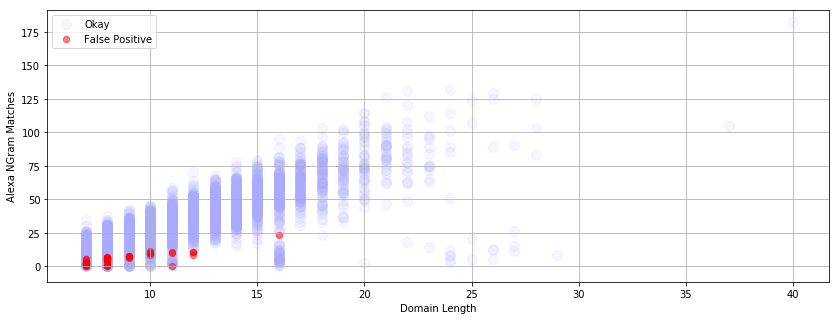

In [140]:
# Okay so on our 10% hold out set of 10k domains about ~100 domains were mis-classified
# at this point we're made some good progress so we're going to claim success :)
#       - Out of 10k domains 100 were mismarked
#       - false positives (Alexa marked as DGA) = ~0.6%
#       - about 80% of the DGA are getting marked

# Note: Alexa 1M results on the 10% hold out (100k domains) were in the same ballpark 
#       - Out of 100k domains 432 were mismarked
#       - false positives (Alexa marked as DGA) = 0.4%
#       - about 70% of the DGA are getting marked

# Now were going to just do some post analysis on how the ML algorithm performed.

# Lets look at a couple of plots to see which domains were misclassified.
# Looking at Length vs. Alexa NGrams
fp_cond = ((hold_out_domains['class'] == 'legit') & (hold_out_domains['pred']=='dga'))
fp = hold_out_domains[fp_cond]
fn_cond = ((hold_out_domains['class'] == 'dba') & (hold_out_domains['pred']=='legit'))
fn = hold_out_domains[fn_cond]
okay = hold_out_domains[hold_out_domains['class'] == hold_out_domains['pred']]
plt.scatter(okay['length'], okay['alexa_grams'], s=100,  c='#aaaaff', label='Okay', alpha=.1)
plt.scatter(fp['length'], fp['alexa_grams'], s=40, c='r', label='False Positive', alpha=.5)
plt.legend()
pylab.xlabel('Domain Length')
pylab.ylabel('Alexa NGram Matches')
pylab.show()

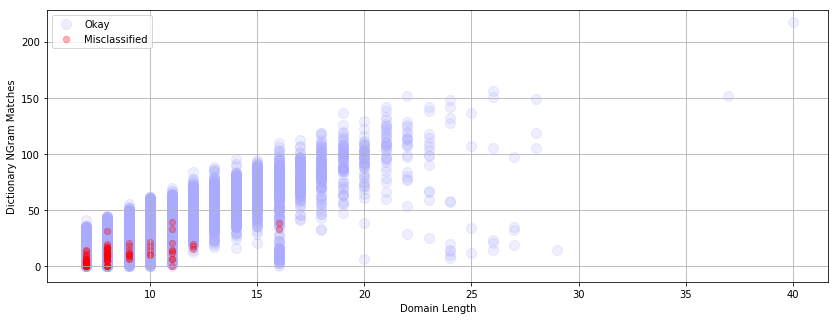

In [141]:
# Looking at Length vs. Dictionary NGrams
cond = (hold_out_domains['class'] != hold_out_domains['pred'])
misclassified = hold_out_domains[cond]
okay = hold_out_domains[~cond]
plt.scatter(okay['length'], okay['word_grams'], s=100,  c='#aaaaff', label='Okay', alpha=.2)
plt.scatter(misclassified['length'], misclassified['word_grams'], s=40, c='r', label='Misclassified', alpha=.3)
plt.legend()
pylab.xlabel('Domain Length')
pylab.ylabel('Dictionary NGram Matches')
pylab.show()

In [142]:
misclassified.head()

,domain,class,length,entropy,alexa_grams,word_grams,pred
276,napisy24,legit,8,3.000000,6.906172,14.909985,dga
307,tuozhe8,legit,7,2.807355,3.538574,3.929215,dga
352,dnp-cdms,legit,8,2.750000,0.000000,0.000000,dga
486,247mahjong,legit,10,3.321928,8.282632,10.303401,dga
546,sklepy24,legit,8,3.000000,4.854937,11.439043,dga


In [143]:
misclassified[misclassified['class'] == 'dga'].head()

,domain,class,length,entropy,alexa_grams,word_grams,pred
8236,usbiezgac,dga,9,3.169925,7.582166,9.172547,legit
8237,ushcnewo,dga,8,3.000000,11.988951,13.904812,legit
8242,utamehz,dga,7,2.807355,10.620263,14.733893,legit
8244,utfowept,dga,8,2.750000,6.912629,16.814295,legit
8245,utghabck,dga,8,3.000000,5.617000,9.172536,legit


In [147]:
# We can also look at what features the learning algorithm thought were the most important
importances = zip(['length', 'entropy', 'alexa_grams', 'word_grams'], clf.feature_importances_)
print(list(importances))

# From the list below we see our feature importance scores. There's a lot of feature selection,
# sensitivity study, etc stuff that you could do if you wanted at this point.

[('length', 0.12255389649504851), ('entropy', 0.14575824287408765), ('alexa_grams', 0.5982319349357379), ('word_grams', 0.13345592569512615)]


In [235]:
# Discussion for how to use the resulting models.
# Typically Machine Learning comes in two phases
#    - Training of the Model
#    - Evaluation of new observations against the Model
# This notebook is about exploration of the data and training the model.
# After you have a model that you are satisfied with, just 'pickle' it
# at the end of the your training script and then in a separate
# evaluation script 'unpickle' it and evaluate/score new observations
# coming in (through a file, or ZeroMQ, or whatever...)
#
# In this case we'd have to pickle the RandomForest classifier
# and the two vectorizing transforms (alexa_grams and word_grams).
# See 'test_it' below for how to use them in evaluation mode.


# test_it shows how to do evaluation, also fun for manual testing below :)
def test_it(domain):
    
    _alexa_match = alexa_counts * alexa_vc.transform([domain]).T  # Woot matrix multiply and transpose Woo Hoo!
    _dict_match = dict_counts * dict_vc.transform([domain]).T
    _X = np.array([len(domain), entropy(domain), _alexa_match[0], _dict_match[0]])
    print('{:s} : {:s}'.format(domain, clf.predict([_X])[0]))

In [236]:
# Examples (feel free to change these and see the results!)
test_it('google')
test_it('google88')
test_it('facebook')
test_it('1cb8a5f36f')
test_it('pterodactylfarts')
test_it('ptes9dro-dwacty2lfa5rrts')
test_it('beyonce')
test_it('bey666on4ce')
test_it('supersexy')
test_it('yourmomissohotinthesummertime')
test_it('35-sdf-09jq43r')
test_it('clicksecurity')

google : legit
google88 : legit
facebook : legit
1cb8a5f36f : dga
pterodactylfarts : legit
ptes9dro-dwacty2lfa5rrts : dga
beyonce : legit
bey666on4ce : dga
supersexy : legit
yourmomissohotinthesummertime : legit
35-sdf-09jq43r : dga
clicksecurity : legit


### Conclusions:
The combination of IPython, Pandas and Scikit Learn let us pull in some junky data, clean it up, plot it, understand it and slap it with some machine learning!

Clearly a lot more formality could be used, plotting learning curves, adjusting for overfitting, feature selection, on and on... there are some really great machine learning resources that cover this deeper material. In particular we highly recommend the work and presentations of Olivier Grisel at INRIA Saclay. http://ogrisel.com/

Some papers on detecting DGA domains:
 
 - S. Yadav, A. K. K. Reddy, A. L. N. Reddy, and S. Ranjan, “Detecting algorithmically generated malicious domain names,” presented at the the 10th annual conference, New York, New York, USA, 2010, pp. 48–61. [http://conferences.sigcomm.org/imc/2010/papers/p48.pdf]
 - S. Yadav, A. K. K. Reddy, A. L. N. Reddy, and S. Ranjan, “Detecting algorithmically generated domain-flux attacks with DNS traffic analysis,” IEEE/ACM Transactions on Networking (TON, vol. 20, no. 5, Oct. 2012.
 - A. Reddy, “Detecting Networks Employing Algorithmically Generated Domain Names,” 2010.
 - Z. Wei-wei and G. Qian, “Detecting Machine Generated Domain Names Based on Morpheme Features,” 2013.
 - P. Barthakur, M. Dahal, and M. K. Ghose, “An Efficient Machine Learning Based Classification Scheme for Detecting Distributed Command & Control Traffic of P2P Botnets,” International Journal of Modern …, 2013.